In [1]:
# For Matrix Operations
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
from PIL import Image

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [2]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    
  return persistence

def Get_Vinyard(f, g, D, t):
##########
    # input:
        # f and g by which you want to interpolate using straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,t)
    # creates homology from f to g using these intervals
    hs = np.array([(t * f) + (1-t) * g for t in ts])
    
    PDD = [persistence(h,dimension = D) for h in hs]

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

    mx = 'hey'
    #mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs
def Plot_Vinyard(res, mx, hs):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            
            v += f(D)*l*dt
            L += l*dt

        v *= g(L)
        V += v

    return V
def fD(D):
    return D/100
def fL(L):
    return 1


In [3]:
image_names = [
  'sandhe.tiff', 'grasshe.tiff', 'brickhe.tiff', 'weavehe.tiff','woodhe.tiff','bubbleshe.tiff','barkhe.tiff'
]
training_set = []
for image_name in image_names:
    full_image = Image.open("./tda-texture-exercise_general/{}".format(image_name))
    full_image_array = np.array(full_image)
    for i in range(5):
        training_set.append(full_image_array[100*i:100*(i+1), 100*i:100*(i+1)])
Training_PDDS_0 = [persistence(image,0) for image in training_set]
Training_PDDS_1 = [persistence(image,1) for image in training_set]





## Wasserstein Distance

In [4]:
Wasserstein_Distance_Matrix_0 = Distance_Matrix = np.empty((35,35))
for i in range(len(training_set)):
    for j in range(i,len(training_set)):
        Wasserstein_Distance_Matrix_0[i,j] = gudhi.hera.wasserstein_distance(Training_PDDS_0[i], Training_PDDS_0[j])

Wasserstein_Distance_Matrix_1 = Distance_Matrix = np.empty((35,35))
for i in range(len(training_set)):
    for j in range(i,len(training_set)):
        Wasserstein_Distance_Matrix_1[i,j] = gudhi.hera.wasserstein_distance(Training_PDDS_1[i], Training_PDDS_1[j])

Wasserstein_Distance_Matrix_0 += Wasserstein_Distance_Matrix_0.transpose()
Wasserstein_Distance_Matrix_1 += Wasserstein_Distance_Matrix_1.transpose()

/var/folders/_b/bl5yw1q15msg5ky9z_04dpt40000gn/T/ipykernel_8775/3183408153.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))


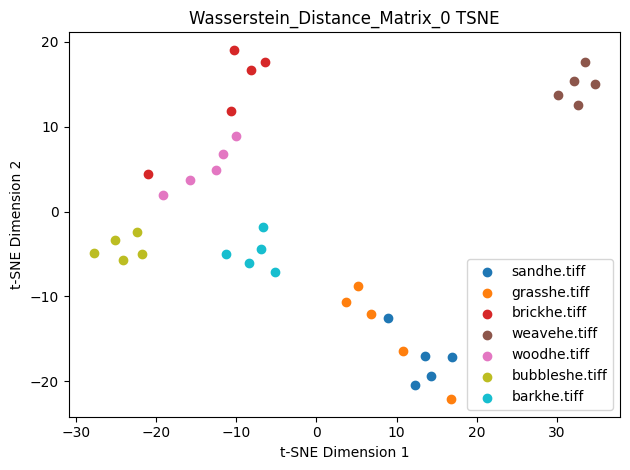

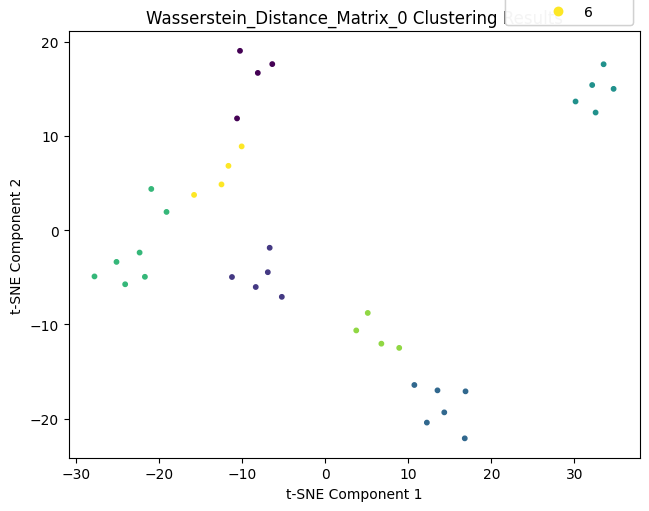

hey we got 30 correct


In [5]:
Dimension_0_TSNE = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Wasserstein_Distance_Matrix_0)
keys = np.repeat(np.arange(len(image_names)), 5)
colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))

for i, (key, color) in enumerate(zip(image_names, colors)):
    plt.scatter(Dimension_0_TSNE[keys == i, 0], Dimension_0_TSNE[keys == i, 1], color=color, label=key)

plt.title('Wasserstein_Distance_Matrix_0 TSNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()

plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(Dimension_0_TSNE)

fig, ax = plt.subplots()

scatter = ax.scatter(Dimension_0_TSNE[:, 0], Dimension_0_TSNE[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Kmeans Clusters", bbox_to_anchor = (1,1))
ax.add_artist(legend1)
plt.tight_layout()
plt.title('Wasserstein_Distance_Matrix_0 Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cm = confusion_matrix(keys, kmeans.labels_)

# Find the maximum count in each row (true label)
correct_pairs = cm.max(axis=1).sum()
print('hey we got {} correct'.format(str(correct_pairs)))

/var/folders/_b/bl5yw1q15msg5ky9z_04dpt40000gn/T/ipykernel_8775/2915149435.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))


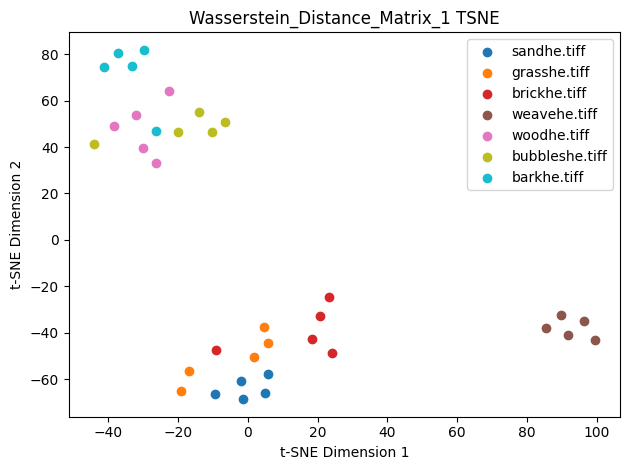

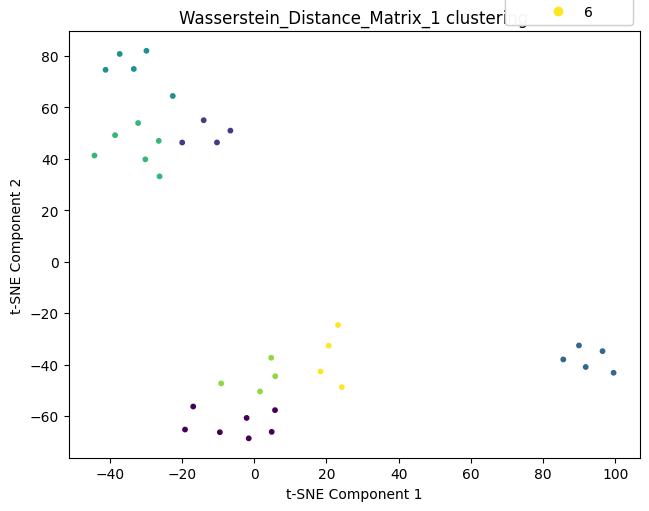

hey we got 29 correct


In [6]:
Dimension_1_TSNE = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Wasserstein_Distance_Matrix_1)
keys = np.repeat(np.arange(len(image_names)), 5)
colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))

for i, (key, color) in enumerate(zip(image_names, colors)):
    plt.scatter(Dimension_1_TSNE[keys == i, 0], Dimension_1_TSNE[keys == i, 1], color=color, label=key)

plt.title('Wasserstein_Distance_Matrix_1 TSNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(Dimension_1_TSNE)

fig, ax = plt.subplots()

scatter = ax.scatter(Dimension_1_TSNE[:, 0], Dimension_1_TSNE[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Kmeans Clusters", bbox_to_anchor = (1,1))
ax.add_artist(legend1)
plt.tight_layout()
plt.title('Wasserstein_Distance_Matrix_1 clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cm = confusion_matrix(keys, kmeans.labels_)

# Find the maximum count in each row (true label)
correct_pairs = cm.max(axis=1).sum()
print('hey we got {} correct'.format(str(correct_pairs)))

## Vinyard Distance

In [7]:
Vinyard_Distances_0 = np.zeros((len(training_set), len(training_set)))

for i in range(len(training_set)):
    for j in range(i+1,len(training_set)):
        Vinyard_Distances_0[i,j] = vdist(Get_Vinyard(training_set[i], training_set[j],0,10)[0],fD,fL)
Vinyard_Distances_0 += np.transpose(Vinyard_Distances_0)


0


/var/folders/_b/bl5yw1q15msg5ky9z_04dpt40000gn/T/ipykernel_8775/304737545.py:151: RuntimeWarning: invalid value encountered in subtract
  l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
/var/folders/_b/bl5yw1q15msg5ky9z_04dpt40000gn/T/ipykernel_8775/304737545.py:157: RuntimeWarning: invalid value encountered in subtract
  D = np.linalg.norm(proj-mid)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


/var/folders/_b/bl5yw1q15msg5ky9z_04dpt40000gn/T/ipykernel_8775/3180827554.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))


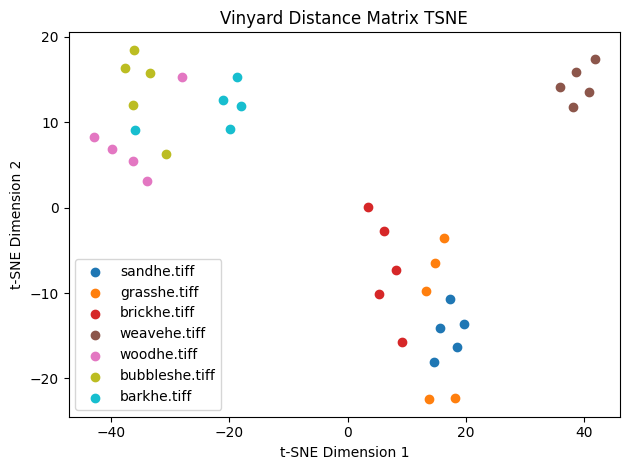

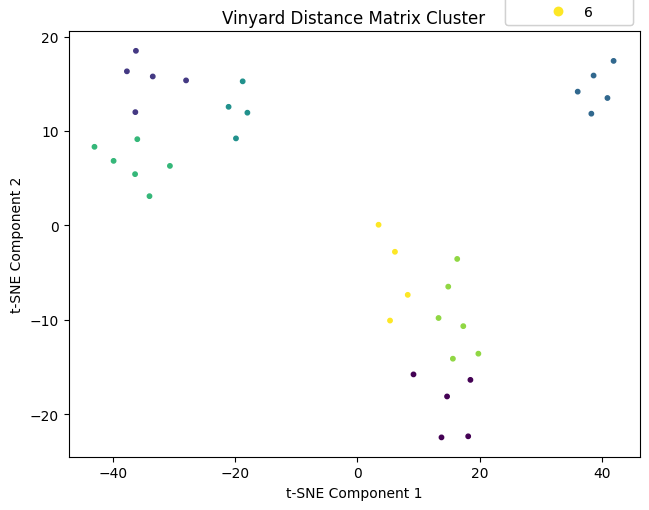

hey we got 27 correct


In [8]:
Vinyard_TSNE_1 = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Wasserstein_Distance_Matrix_1)
keys = np.repeat(np.arange(len(image_names)), 5)
colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))

for i, (key, color) in enumerate(zip(image_names, colors)):
    plt.scatter(Vinyard_TSNE_1[keys == i, 0], Vinyard_TSNE_1[keys == i, 1], color=color, label=key)

plt.title('Vinyard Distance Matrix TSNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(Vinyard_TSNE_1)

fig, ax = plt.subplots()

scatter = ax.scatter(Vinyard_TSNE_1[:, 0], Vinyard_TSNE_1[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Kmeans Clusters", bbox_to_anchor = (1,1))
ax.add_artist(legend1)
plt.tight_layout()
plt.title('Vinyard Distance Matrix Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cm = confusion_matrix(keys, kmeans.labels_)

# Find the maximum count in each row (true label)
correct_pairs = cm.max(axis=1).sum()
print('hey we got {} correct'.format(str(correct_pairs)))

## Large test set

In [4]:
# training set large has 175 images total

training_set_large = []
for image_name in image_names:
    full_image = Image.open("./tda-texture-exercise_general/{}".format(image_name))
    full_image_array = np.array(full_image)
    for i in range(5):
        for j in range(2):
            training_set_large.append(full_image_array[100*i:100*(i+1), 100*j:100:(j+1)])

# keys for legend
keys = np.repeat(np.arange(len(image_names)), 10)

# Calculating persistence
Training_large_PDDS_0 = [persistence(image,0) for image in training_set_large]
Training_large_PDDS_1 = [persistence(image,1) for image in training_set_large]


# Calculating Wasserstein distance
Wasserstein_Distance_Matrix_0 = np.empty((70,70))
for i in range(len(training_set)):
    for j in range(i,len(training_set)):
        Wasserstein_Distance_Matrix_0[i,j] = gudhi.hera.wasserstein_distance(Training_large_PDDS_0[i], Training_large_PDDS_0[j])

Wasserstein_Distance_Matrix_1 = np.empty((70,70))
for i in range(len(training_set)):
    for j in range(i,len(training_set)):
        Wasserstein_Distance_Matrix_1[i,j] = gudhi.hera.wasserstein_distance(Training_large_PDDS_1[i], Training_large_PDDS_1[j])

Wasserstein_Distance_Matrix_0 += Wasserstein_Distance_Matrix_0.transpose()
Wasserstein_Distance_Matrix_1 += Wasserstein_Distance_Matrix_1.transpose()




: 

In [ ]:
# calculating vinyard distance
Vinyard_Distances_0 = np.zeros((len(training_set), len(training_set)))

for i in range(len(training_set)):
    print(i)
    for j in range(i+1,len(training_set)):
        Vinyard_Distances_0[i,j] = vdist(Get_Vinyard(training_set[i], training_set[j],0,10)[0],fD,fL)
Vinyard_Distances_0 += np.transpose(Vinyard_Distances_0)

### Plotting

Vinyard Distance Clustering

In [4]:
Vinyard_TSNE_1 = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Wasserstein_Distance_Matrix_1)
keys = np.repeat(np.arange(len(image_names)), 5)
colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))

for i, (key, color) in enumerate(zip(image_names, colors)):
    plt.scatter(Vinyard_TSNE_1[keys == i, 0], Vinyard_TSNE_1[keys == i, 1], color=color, label=key)

plt.title('Vinyard Distance Matrix TSNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(Vinyard_TSNE_1)

fig, ax = plt.subplots()

scatter = ax.scatter(Vinyard_TSNE_1[:, 0], Vinyard_TSNE_1[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Kmeans Clusters", bbox_to_anchor = (1,1))
ax.add_artist(legend1)
plt.tight_layout()
plt.title('Vinyard Distance Matrix Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cm = confusion_matrix(keys, kmeans.labels_)

# Find the maximum count in each row (true label)
correct_pairs = cm.max(axis=1).sum()
print('hey we got {} correct'.format(str(correct_pairs)))

NameError: name 'Wasserstein_Distance_Matrix_1' is not defined

Wasserstein distance clustering

In [ ]:
################################################################################################################################################
# PLOTTING DIMENSION 0 #
############################################################################################################################################

print('plotting dimension zero')


Dimension_0_TSNE = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Wasserstein_Distance_Matrix_0)
keys = np.repeat(np.arange(len(image_names)), 5)
colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))

for i, (key, color) in enumerate(zip(image_names, colors)):
    plt.scatter(Dimension_0_TSNE[keys == i, 0], Dimension_0_TSNE[keys == i, 1], color=color, label=key)

plt.title('Wasserstein_Distance_Matrix_0 TSNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()

plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(Dimension_0_TSNE)

fig, ax = plt.subplots()

scatter = ax.scatter(Dimension_0_TSNE[:, 0], Dimension_0_TSNE[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Kmeans Clusters", bbox_to_anchor = (1,1))
ax.add_artist(legend1)
plt.tight_layout()
plt.title('Wasserstein_Distance_Matrix_0 Clustering Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cm = confusion_matrix(keys, kmeans.labels_)

# Find the maximum count in each row (true label)
correct_pairs = cm.max(axis=1).sum()
print('hey we got {} correct'.format(str(correct_pairs)))


#################################################################################################################################################
# PLOTTING DIMENSION 1 #
#################################################################################################################################################
print('plotting dimension One')

Dimension_1_TSNE = TSNE(n_components = 2, metric = 'precomputed', init = 'random', perplexity = 5).fit_transform(Wasserstein_Distance_Matrix_1)
keys = np.repeat(np.arange(len(image_names)), 5)
colors = plt.cm.get_cmap('tab10', len(image_names))(np.arange(len(image_names)))

for i, (key, color) in enumerate(zip(image_names, colors)):
    plt.scatter(Dimension_1_TSNE[keys == i, 0], Dimension_1_TSNE[keys == i, 1], color=color, label=key)

plt.title('Wasserstein_Distance_Matrix_1 TSNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(Dimension_1_TSNE)

fig, ax = plt.subplots()

scatter = ax.scatter(Dimension_1_TSNE[:, 0], Dimension_1_TSNE[:, 1], c = clusters, s=10)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Kmeans Clusters", bbox_to_anchor = (1,1))
ax.add_artist(legend1)
plt.tight_layout()
plt.title('Wasserstein_Distance_Matrix_1 clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cm = confusion_matrix(keys, kmeans.labels_)

# Find the maximum count in each row (true label)
correct_pairs = cm.max(axis=1).sum()
print('hey we got {} correct'.format(str(correct_pairs)))
